<a href="https://colab.research.google.com/github/samaalharbi2/T5/blob/main/Exam_Copy_of_Time_Series_Forecasting_Practical_EvaluationSama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [ ]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 53.2MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from keras.preprocessing import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Dropout,GRU
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error
SEED = 42
np.random.seed(SEED)
import warnings
warnings.filterwarnings('ignore')


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [ ]:
df = pd.read_csv('/content/Traffic Data.csv',parse_dates=['date_time'],index_col='date_time')

In [ ]:
df.head()
#temp >>> convert to Celsius temperature

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [ ]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear
2018-02-12 15:00:00,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds
2018-05-31 18:00:00,5042.0,301.65,0.0,0.0,40,Clouds,scattered clouds


In [ ]:
df.sample()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-04-14 05:00:00,2425.0,281.65,0.0,0.0,90,Clouds,overcast clouds


# rain_1h & snow_1h alawys zero

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


# traffic_volume 19980 non-null  >>> missing value

In [ ]:
df.dtypes

,0
traffic_volume,float64
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object


In [ ]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [ ]:
df.describe(include='object')

,weather_main,weather_description
count,20000,20000
unique,10,34
top,Clear,sky is clear
freq,5614,5514


In [ ]:
# we have three columns have outliers
for col in df.columns:
  fig=px.box(df,y=col)
  fig.show()

In [ ]:
q1 = df['traffic_volume'].quantile(0.25)
q3= df['traffic_volume'].quantile(0.75)
iqr =q3-q1

In [ ]:
lower = q1- (1.5*iqr)

upper = q3 + (1.5*iqr)

upper

10476.875

In [ ]:
outliers_fliter = df.loc[(df['traffic_volume']< lower)|(df['traffic_volume']> upper)]

In [ ]:
new_df = df.copy()

In [ ]:
new_df.loc[(df['traffic_volume'] < lower) , 'traffic_volume'] = lower
new_df.loc [(df['traffic_volume'] > upper) , 'traffic_volume'] = upper

In [ ]:
fig = figsize=(7,9)
fig=px.box(new_df['traffic_volume'])
fig.show()

In [ ]:
len(new_df)

20000

In [ ]:
df_encoded = pd.get_dummies(new_df, columns=['weather_main', 'weather_description'])
print(df_encoded)

                     traffic_volume    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                                   
2017-08-27 01:00:00          1209.0  291.15      0.0      0.0          90   
2018-09-06 23:00:00          1248.0  286.01      0.0      0.0           1   
2017-08-25 18:00:00          4602.0  293.69      0.0      0.0          75   
2017-11-09 22:00:00          2838.0  262.35      0.0      0.0           1   
2017-11-09 15:00:00          5794.0  267.08      0.0      0.0           5   
...                             ...     ...      ...      ...         ...   
2018-06-06 21:00:00          2723.0  296.42      0.0      0.0          40   
2017-10-25 15:00:00          5895.0  285.58      0.0      0.0          40   
2018-03-28 23:00:00          1132.0  275.30      0.0      0.0           1   
2018-02-12 15:00:00          5525.0  260.94      0.0      0.0          75   
2018-05-31 18:00:00          5042.0  301.65      0.0      0.0          40   

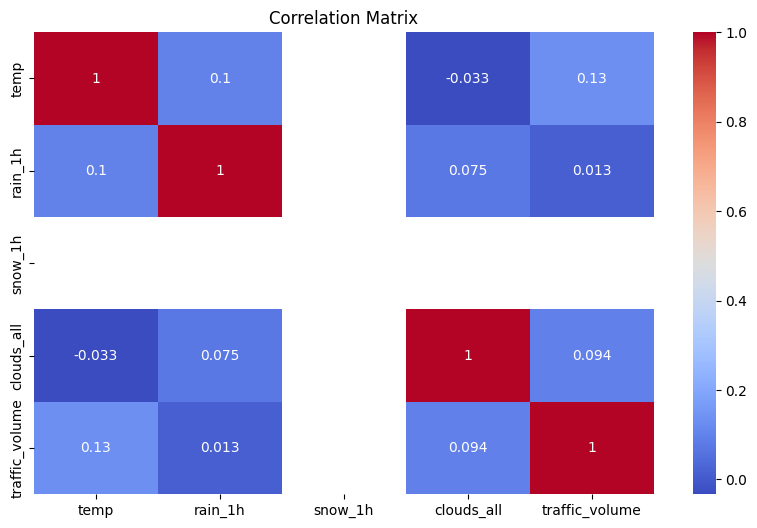

In [ ]:
# Exploring Correlations
correlation_matrix = new_df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# here we notied the column temp and the target column > traffic_volum strong positive relationship

In [ ]:
new_df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [ ]:
new_df['traffic_volume'].unique()

array([1209., 1248., 4602., ..., 6742., 1783., 1132.])

In [ ]:
new_df['traffic_volume'].value_counts()

,count
traffic_volume,
353.0,29
340.0,22
373.0,22
358.0,22
344.0,22
...,...
4176.0,1
5646.0,1
2290.0,1


In [ ]:
new_df['traffic_volume'].fillna(new_df['traffic_volume'].mean(), inplace=True)

In [ ]:
columns = ['weather_main', 'weather_description']
new_df.drop(new_df[columns], axis=1,inplace=True)

In [ ]:
new_df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [ ]:
scaler = MinMaxScaler()
print(scaler.fit_transform(new_df))

[[0.10575195 0.71625675 0.         0.         0.97826087]
 [0.10951502 0.63917217 0.         0.         0.01086957]
 [0.43313915 0.75434913 0.         0.         0.81521739]
 ...
 [0.0983223  0.47855429 0.         0.         0.01086957]
 [0.5221985  0.26319736 0.         0.         0.81521739]
 [0.47559431 0.87372525 0.         0.         0.43478261]]


In [ ]:
new_df.index

DatetimeIndex(['2017-08-27 01:00:00', '2018-09-06 23:00:00',
               '2017-08-25 18:00:00', '2017-11-09 22:00:00',
               '2017-11-09 15:00:00', '2018-06-09 12:00:00',
               '2018-07-26 19:00:00', '2018-08-03 15:00:00',
               '2018-01-10 20:00:00', '2018-08-09 00:00:00',
               ...
               '2017-09-05 05:00:00', '2018-04-06 11:00:00',
               '2018-08-03 23:00:00', '2017-08-10 02:00:00',
               '2017-03-21 07:00:00', '2018-06-06 21:00:00',
               '2017-10-25 15:00:00', '2018-03-28 23:00:00',
               '2018-02-12 15:00:00', '2018-05-31 18:00:00'],
              dtype='datetime64[ns]', name='date_time', length=20000, freq=None)

In [ ]:
scaler = MinMaxScaler()
numerical_imputer = SimpleImputer(strategy='mean')
pip = make_pipeline(('minmaxscaler' ,scaler ),
                         ('numerical_imputer' ,numerical_imputer))
pip_pre=pip.fit_transform(new_df)

In [ ]:
# Here I wanted to make a pipeline, but an error appeared, so I used the known method.
scaler = MinMaxScaler()
numerical_imputer = SimpleImputer(strategy= 'mean')
pip = make_pipeline(('minmaxscaler' ,scaler ),
                         ('numerical_imputer' ,numerical_imputer))
pip_pre=pip.fit_transform(new_df,new_df.index ,new_df.columns)

AttributeError: This 'Pipeline' has no attribute 'fit_transform'

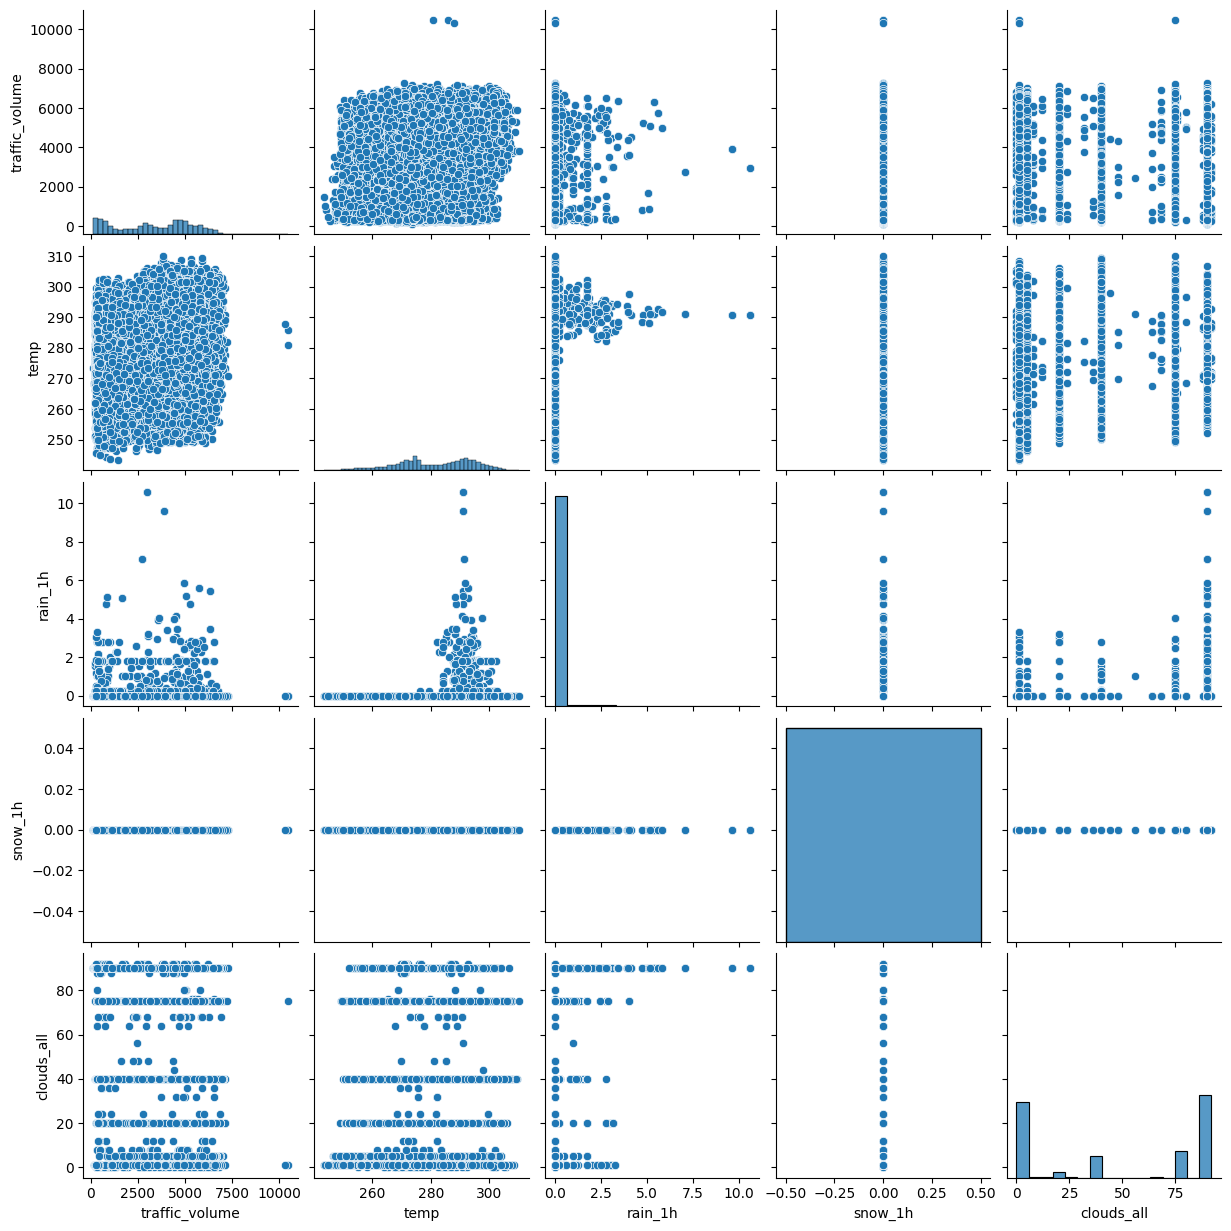

In [ ]:
# distrubtion
fig =figsize=(7,8)
sns.pairplot(new_df)
plt.show()

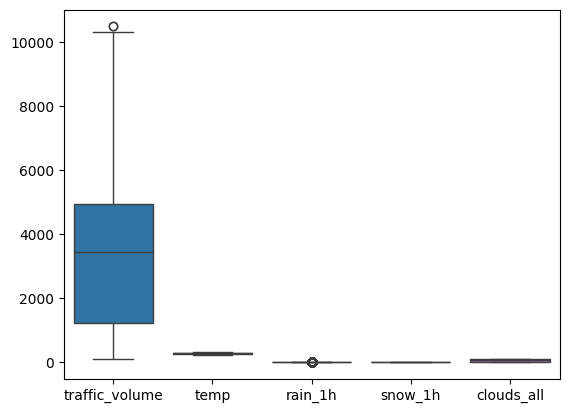

In [ ]:
fig = figsize=(7,8)
sns.boxplot(new_df)
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [ ]:
new_df['prev_traffic_volume'] = new_df['traffic_volume'].shift(1)

In [ ]:
#new_df.sort_indx()

AttributeError: 'DataFrame' object has no attribute 'sort_indx'

In [ ]:
# the date_time is not sorted
new_df.head()
#new_df['Date_time'].max()
#new_df['Date_time'].min()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,prev_traffic_volume,day_of_week,month,hour
date_time,,,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,NaN,6,8,239
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,39.0,3,9,249
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,3354.0,4,8,237
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,-1764.0,3,11,313
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,2956.0,3,11,313


In [ ]:
new_df['prev_traffic_volume'].isnull().sum()

1

In [ ]:
new_df.dropna(inplace=True)

In [ ]:
new_df['prev_traffic_volume'].fillna(new_df['prev_traffic_volume'].mean(), inplace=True)

In [ ]:
new_df['prev_traffic_volume'] = new_df['traffic_volume'].diff()

In [ ]:
new_df['day_of_week'] = new_df.index.dayofweek
new_df['month'] = new_df.index.month
new_df['day_of_year'] = new_df.index.dayofyear

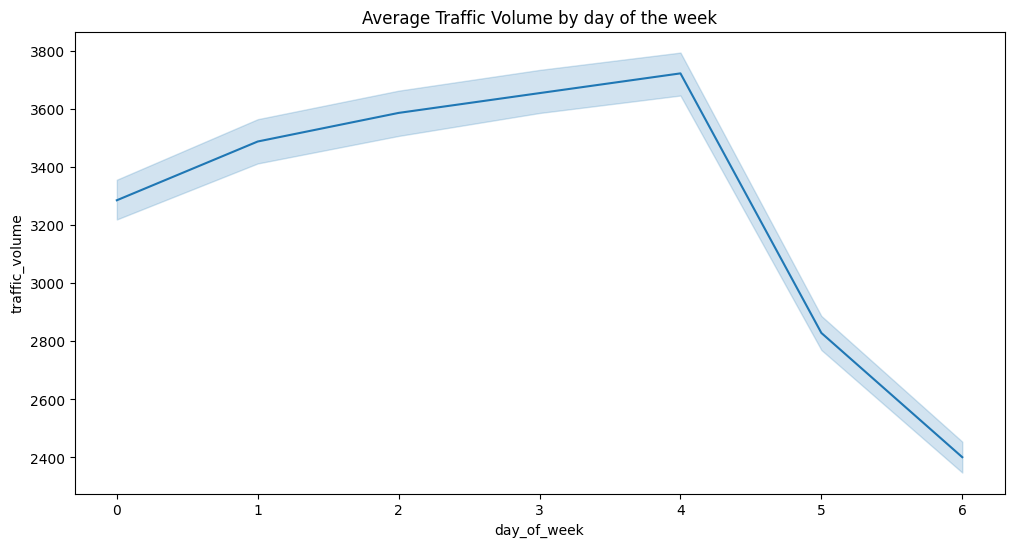

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(new_df, x ='day_of_week', y='traffic_volume')
plt.xlabel('day_of_week')
plt.ylabel('traffic_volume')
plt.title('Average Traffic Volume by day of the week')
plt.show()

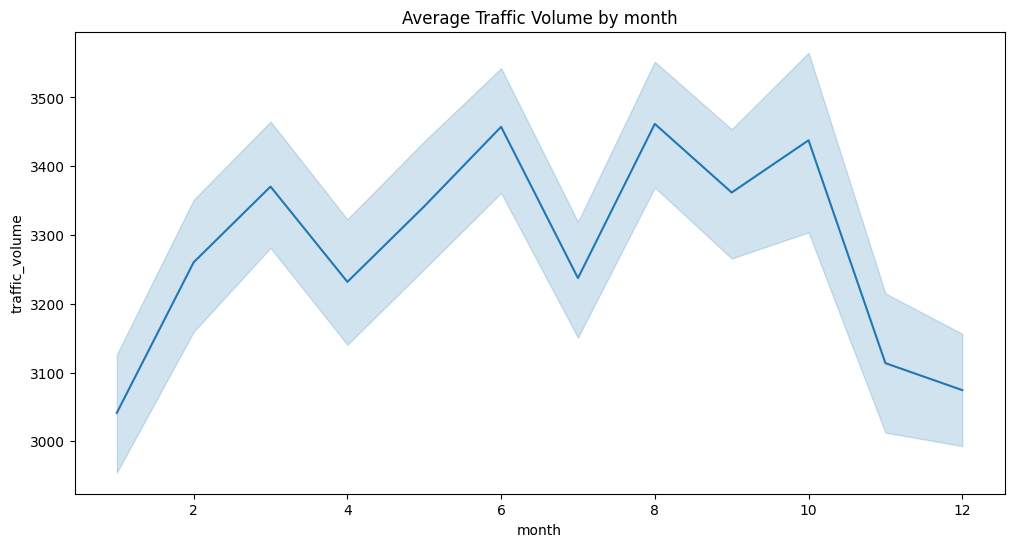

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(new_df, x= 'month', y='traffic_volume')
plt.xlabel('month')
plt.ylabel('traffic_volume')
plt.title('Average Traffic Volume by month')
plt.show()


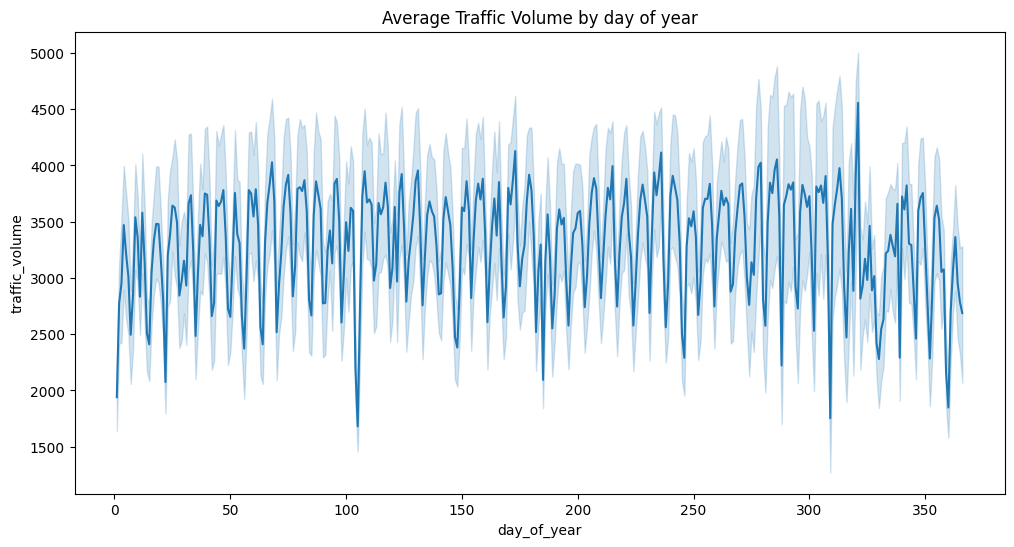

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(new_df, x='day_of_year', y='traffic_volume')
plt.xlabel('day_of_year')
plt.ylabel('traffic_volume')
plt.title('Average Traffic Volume by day of year')
plt.show()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [ ]:
x = new_df.drop(columns=['traffic_volume']) # All FEATURES except
y = new_df['traffic_volume'] # ONLY traffic_volume

train_data,test_data , y_train , y_test = train_test_split(x,y,test_size=0.3,shuffle= False,random_state=42)
val_data, test_data, y_val, y_test = train_test_split(test_data, y_test, test_size=0.5, shuffle=False)
# i want to see the shape
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Testing data shape:", test_data.shape)
#I wanted to work only on temperature and traffic_volume by the datetime because there is a big relationship between them unlike other features.

Training data shape: (13999, 9)
Validation data shape: (3000, 9)
Testing data shape: (3000, 9)


# 9 columns

##  here we want to create function raleted about time serice

In [ ]:
def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        labels.append(target[i + window_size])
    return np.array(sequences), np.array(labels)

In [ ]:
window_size = 10
X_train, y_train_s = create_sequences(train_data, y_train.values, window_size)
X_val, y_val_s= create_sequences(val_data, y_val.values, window_size)
X_test, y_test_s = create_sequences(test_data, y_test.values, window_size)

In [ ]:
def create_sequences(data,target,window_size):
  seqeunce = []
  labels = []
  for i in range(len(data) - window_size):
    seqeunce.append(data[i:i+ window_size])
    labels.append(target[i+ window_size])
  return np.arrary(seqeunce), np.array(labels)

In [ ]:
window_size = 10
X_train,y_train_s= create_sequences(train_data,y_train.values, window_size)
X_val,y_val_s= create_sequences(val_data,y_val.values, window_size)
X_tesst,y_test_s= create_sequences(test_data,y_test.values, window_size)

AttributeError: module 'numpy' has no attribute 'arrary'

In [ ]:
window_size = 10
X_train, y_train_seq = create_seqeunce(train_data, y_train.values, window_size)
X_val, y_val_seq = create_seqeunce(val_data, y_val.values, window_size)
X_test, y_test_seq = create_seqeunce(test_data, y_test.values, window_size)

AttributeError: module 'numpy' has no attribute 'arrary'

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [ ]:
# i use MinMaxScaler in all new_df

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# i choose RNN model AND LSTM

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [ ]:
rnn_model = Sequential() # import vSequential
rnn_model.add(SimpleRNN(units=10,activation='tanh',return_sequences=False, input_shape=(X_train[1],X_train.shape[2])))# here we have ten layers
rnn_model.add(SimpleRNN(units=1))# this output

ValueError: Invalid dtype: ndarray

In [ ]:
rnn_model= Sequential() # import vSequential
rnn_model.add(SimpleRNN(units =50,activation='tanh',return_sequences=False, input_shape= (X_train[1], X_train.shape[2])))# here we have ten layers
rnn_model.add(Dense(units(1)))# this output # this error

ValueError: Invalid dtype: ndarray

In [ ]:
rnn_model= Sequential() # import vSequential
rnn_model.add(SimpleRNN(units=50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))# return >> false if we have two layers >> True
rnn_model.add(Dense(1))# this output

In [ ]:
# now set up confg
rnn_model.compile(optimizer ='adam',loss='mse',metrics =['mae'])

In [ ]:
# the last step here train the model of RNN
history_rnn = rnn_model.fit(X_train, y_train_s, epochs=3, batch_size=32, validation_data=(X_val, y_val_s))# i choose epochs=3 cuz i dont have any time

Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 14639686.0000 - mae: 3274.9685 - val_loss: 14337975.0000 - val_mae: 3239.2236
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 14408553.0000 - mae: 3243.6797 - val_loss: 14158343.0000 - val_mae: 3211.3835
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 14296373.0000 - mae: 3223.8174 - val_loss: 13976823.0000 - val_mae: 3183.0291


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
# Evaluate >>>> test data
y_testpred_rnn = rnn_model.predict(X_test)
y_testpred_rnn

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[73.460045],
       [73.460045],
       [73.70751 ],
       ...,
       [73.70751 ],
       [73.460045],
       [73.70751 ]], dtype=float32)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
#  MSE for model
mse_rnn = mean_squared_error(y_test_s, y_testpred_rnn)
mse_rnn

14552212.459765844

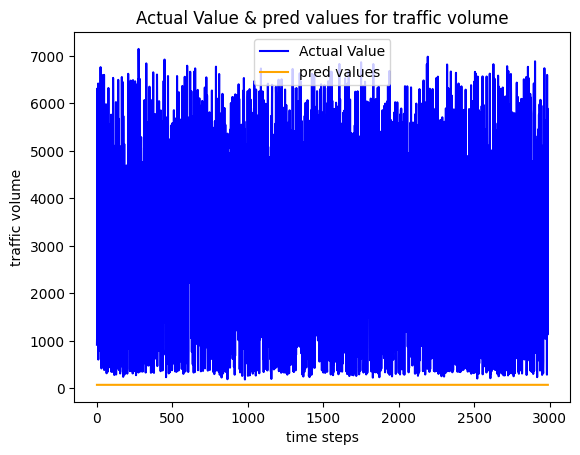

In [ ]:
fig = figsize=(12,8)
plt.plot(y_test_s,label='Actual Value',color = 'blue')
plt.plot(y_testpred_rnn,label='pred values',color='orange',linestyle='-')
plt.title('Actual Value & pred values for traffic volume')
plt.xlabel('time steps')
plt.ylabel('traffic volume')
plt.legend()
plt.show()

In [ ]:
#it doesn't make any sense i think the data is not in the range of zero and one >(MinMaxScaler), and I also did not arrange the date because I get an error.
# also RNN model is not good

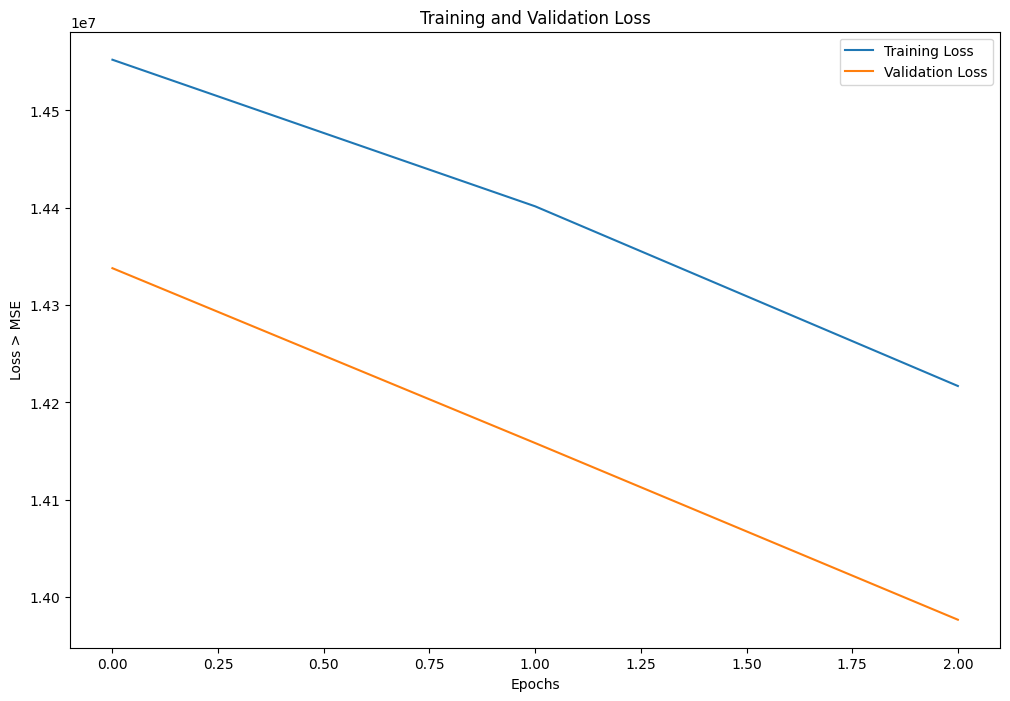

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss > MSE')
plt.legend()
plt.show()

In [ ]:
# GAP BETWEEN >>> train and validation

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [ ]:
LSTM_model= Sequential() # import vSequential
LSTM_model.add(LSTM(units=50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))# return >> false if we have two layers >> True
LSTM_model.add(Dense(1))# this output

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
# Evaluate >>>> test data
y_testpred_LSTM = LSTM_model.predict(X_test)
y_testpred_LSTM

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[-0.21611814],
       [ 0.27196273],
       [ 0.04733774],
       ...,
       [ 0.55165464],
       [ 0.21084714],
       [ 0.51848245]], dtype=float32)

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
#  MSE for model
LSTM_model = mean_squared_error(y_test_s, y_testpred_LSTM)
LSTM_model

15038320.619053343

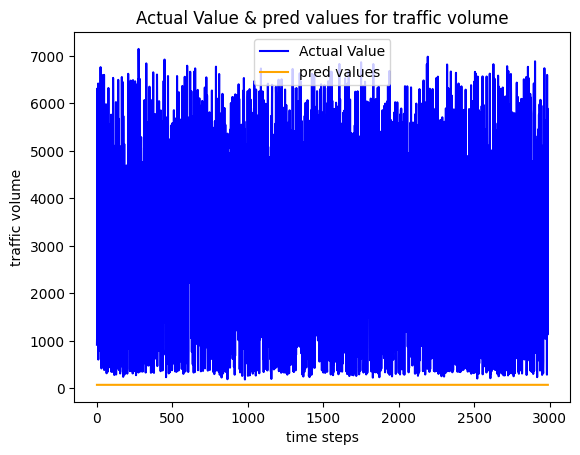

In [ ]:
fig = figsize=(12,8)
plt.plot(y_test_s,label='Actual Value',color = 'blue')
plt.plot(y_testpred_rnn,label='pred values',color='orange',linestyle='-')
plt.title('Actual Value & pred values for traffic volume')
plt.xlabel('time steps')
plt.ylabel('traffic volume')
plt.legend()
plt.show()

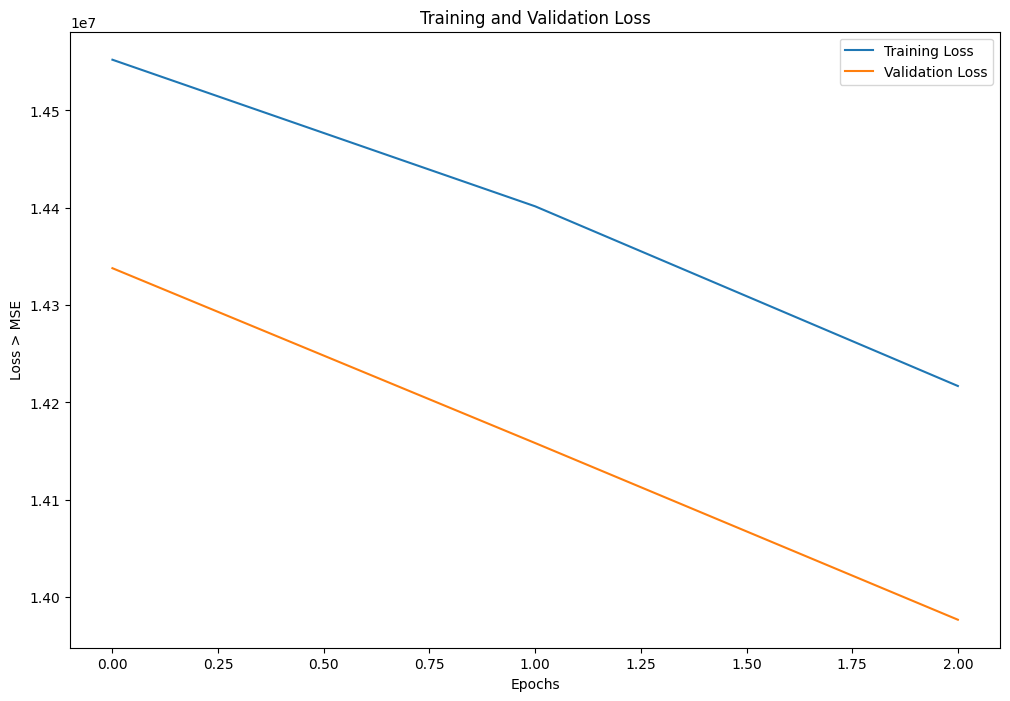

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss > MSE')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

In [ ]:
# we have only column missing value >> traffic volume i used mean
# we know how to detect outliers
# 1- keep them
# 2- delete them
#3- copy of the data like i did it > traffic volume
#I also wanted to use pipeline but I had some minor errors.but i use another way
#I did data engineering for the column traffic volume using shift > and diff
#i use two models RNN & LSTM , number of neurons >> 50
#Number of epchos 3 due to time constraints
# The known batch is 32
#I got a Overfitting in all models because I did not try more in the number of networks or other number of epochs. Also,
# the data was not in the range of zero and one to unify the data(StandardScaler,MinMaxScaler), of course, due to the lack of time.
# "The deeeeeeper the networks, the betttttter the results."

### Answer Here: